*Stanislav Borysov [stabo@dtu.dk], DTU Management*
# Advanced Business Analytics

## Probability Calibration in Classification

**Note: In this notebook, you are not supposed to write your own code. Please go through the notebook and make sure you understand the code and main concepts.**

### 1. Comparison of Calibration of Classifiers

*Based on https://scikit-learn.org/stable/auto_examples/calibration/plot_compare_calibration.html*

Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approx. 80% actually belong to the positive class.

LogisticRegression returns well calibrated predictions as it directly optimizes log-loss. In contrast, the other methods return biased probabilities, with different biases per method:

- [GaussianNaiveBayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) tends to push probabilities to 0 or 1 (note the counts in the histograms). This is mainly because it makes the assumption that features are conditionally independent given the class, which is not the case in this dataset which contains 2 redundant features.

- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) shows the opposite behavior: the histograms show peaks at approx. 0.2 and 0.9 probability, while probabilities close to 0 or 1 are very rare. An explanation for this is given by Niculescu-Mizil and Caruana [1]: “Methods such as bagging and random forests that average predictions from a base set of models can have difficulty making predictions near 0 and 1 because variance in the underlying base models will bias predictions that should be near zero or one away from these values. Because predictions are restricted to the interval [0,1], errors caused by variance tend to be one- sided near zero and one. For example, if a model should predict p = 0 for a case, the only way bagging can achieve this is if all bagged trees predict zero. If we add noise to the trees that bagging is averaging over, this noise will cause some trees to predict values larger than 0 for this case, thus moving the average prediction of the bagged ensemble away from 0. We observe this effect most strongly with random forests because the base-level trees trained with random forests have relatively high variance due to feature subsetting.” As a result, the calibration curve shows a characteristic sigmoid shape, indicating that the classifier could trust its “intuition” more and return probabilities closer to 0 or 1 typically.

- [Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (SVC) shows an even more sigmoid curve as the RandomForestClassifier, which is typical for maximum-margin methods (compare Niculescu-Mizil and Caruana [1]), which focus on hard samples that are close to the decision boundary (the support vectors).

*References:*

[1]
Predicting Good Probabilities with Supervised Learning, A. Niculescu-Mizil & R. Caruana, ICML 2005

/Users/borysov/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/borysov/py3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


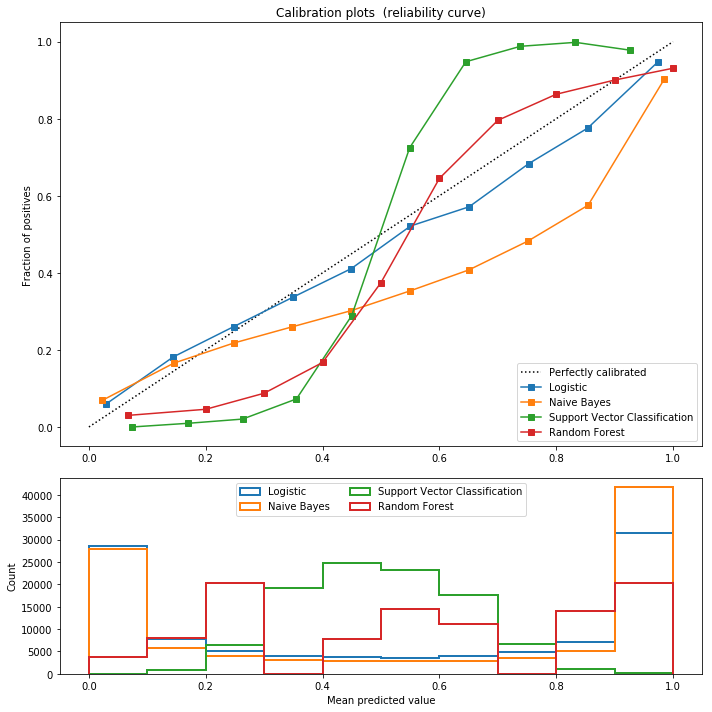

In [2]:
# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)

train_samples = 100  # Samples used for training the models

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier()


# #############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(lr, 'Logistic'),
                  (gnb, 'Naive Bayes'),
                  (svc, 'Support Vector Classification'),
                  (rfc, 'Random Forest')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

### 2. Probability Calibration curves

*Based on https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html*

When performing classification one often wants to predict not only the class label, but also the associated probability. This probability gives some kind of confidence on the prediction. This example demonstrates how to display how well calibrated the predicted probabilities are and how to calibrate an uncalibrated classifier.

The experiment is performed on an artificial dataset for binary classification with 100,000 samples (1,000 of them are used for model fitting) with 20 features. Of the 20 features, only 2 are informative and 10 are redundant. The first figure shows the estimated probabilities obtained with logistic regression, Gaussian naive Bayes, and Gaussian naive Bayes with both isotonic calibration and sigmoid calibration. The calibration performance is evaluated with Brier score, reported in the legend (the smaller the better). One can observe here that logistic regression is well calibrated while raw Gaussian naive Bayes performs very badly. This is because of the redundant features which violate the assumption of feature-independence and result in an overly confident classifier, which is indicated by the typical transposed-sigmoid curve.

Calibration of the probabilities of Gaussian naive Bayes with isotonic regression can fix this issue as can be seen from the nearly diagonal calibration curve. Sigmoid calibration also improves the brier score slightly, albeit not as strongly as the non-parametric isotonic regression. This can be attributed to the fact that we have plenty of calibration data such that the greater flexibility of the non-parametric model can be exploited.

The second figure shows the calibration curve of a linear support-vector classifier (LinearSVC). LinearSVC shows the opposite behavior as Gaussian naive Bayes: the calibration curve has a sigmoid curve, which is typical for an under-confident classifier. In the case of LinearSVC, this is caused by the margin property of the hinge loss, which lets the model focus on hard samples that are close to the decision boundary (the support vectors).

Both kinds of calibration can fix this issue and yield nearly identical results. This shows that sigmoid calibration can deal with situations where the calibration curve of the base classifier is sigmoid (e.g., for LinearSVC) but not where it is transposed-sigmoid (e.g., Gaussian naive Bayes).

/Users/borysov/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

Naive Bayes:
	Brier: 0.118
	Precision: 0.857
	Recall: 0.876
	F1: 0.867

Naive Bayes + Isotonic:
	Brier: 0.098
	Precision: 0.883
	Recall: 0.836
	F1: 0.859

Naive Bayes + Sigmoid:
	Brier: 0.109
	Precision: 0.861
	Recall: 0.871
	F1: 0.866



/Users/borysov/py3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC:
	Brier: 0.163
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC + Isotonic:
	Brier: 0.100
	Precision: 0.853
	Recall: 0.878
	F1: 0.865

SVC + Sigmoid:
	Brier: 0.099
	Precision: 0.874
	Recall: 0.849
	F1: 0.861



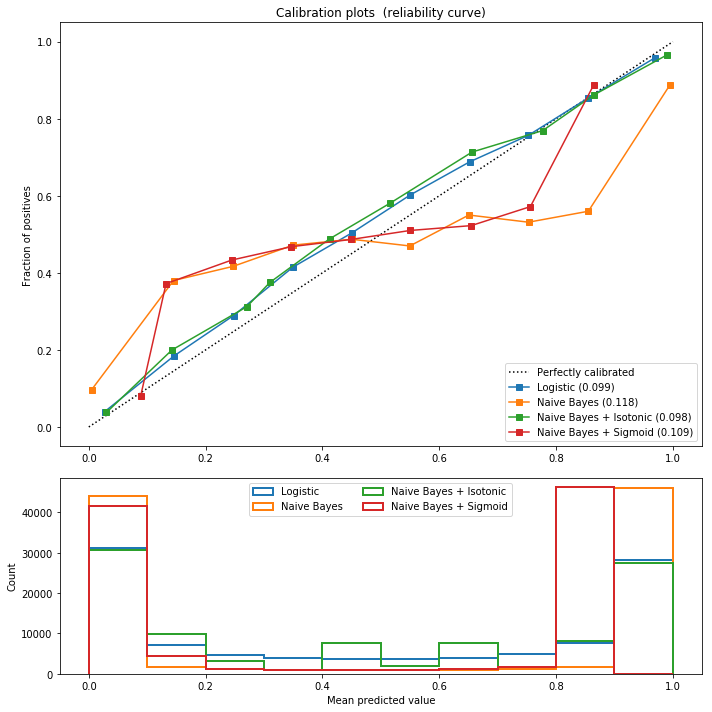

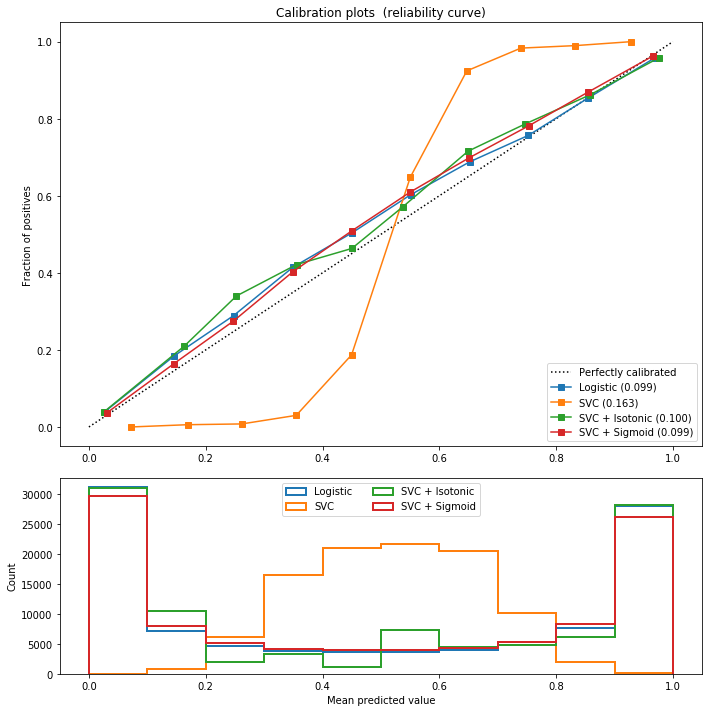

In [3]:
# Author: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split


# Create dataset of classification task with many redundant and few
# informative features
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)

plt.show()